In [35]:
import re
import random
from collections import Counter
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
from scipy.stats import scoreatpercentile

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

import emoji
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.utils import resample, compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, IsolationForest
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    precision_recall_fscore_support
)

from catboost import CatBoostClassifier, Pool

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments
)
from transformers.modeling_outputs import SequenceClassifierOutput

import datasets

In [13]:
data = pd.read_csv('/kaggle/input/data-comments/data_comments.csv')
data.sample(5)

,id,post_id,user_id,text,date,fraud
1776,12101526,70624,7.753234e+09,"Наверное, там много мемов!",2025-04-16 20:09:25,0
959,17866603,68215,1.566869e+09,"Человек смог заработать 32 🍋, а мозгов как у п...",2025-03-30 17:35:36,0
4108,12128886,70864,7.092739e+09,Печально (((,2025-04-22 09:45:21,0
287,650335,31495,1.311523e+09,На лето пересаживаемся на самокаты,2025-03-30 16:36:32,0
3475,12125450,70812,6.708799e+09,Скажу так во мне русская и украинская кровь ес...,2025-04-21 15:14:02,0


In [14]:
data['fraud'].value_counts()

fraud
0    6833
1     295
Name: count, dtype: int64

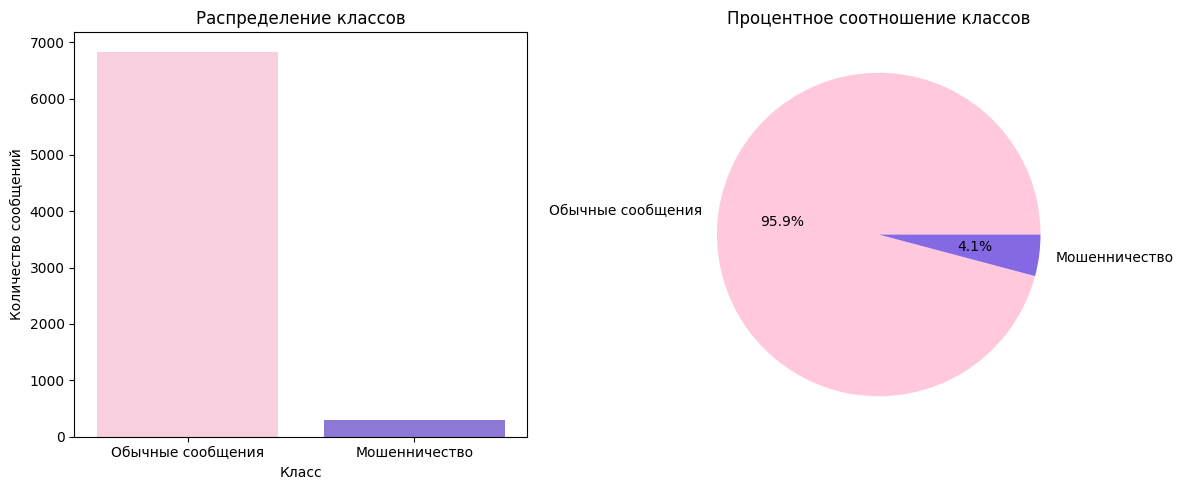

In [15]:
labels = ['Обычные сообщения', 'Мошенничество']
counts = data['fraud'].value_counts()

pink = '#FFC8DD'
violet = '#8569E4'
custom_colors = [pink, violet]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x=counts.index, y=counts.values, palette=custom_colors, ax=axes[0])
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(labels)
axes[0].set_title('Распределение классов')
axes[0].set_ylabel('Количество сообщений')
axes[0].set_xlabel('Класс')

axes[1].pie(counts.values, labels=labels, autopct='%1.1f%%', colors=custom_colors)
axes[1].set_title('Процентное соотношение классов')

plt.tight_layout()
plt.show()


Видно, что данные **сильно несбалансированы** (очень мало мошеннических сообщений). Мы учтем это далее.

In [16]:
print(f"Shape: {data.shape}")
print("Пропуски:\n", data.isnull().sum())

Shape: (7128, 6)
Пропуски:
 id           0
post_id      0
user_id    208
text        71
date         3
fraud        0
dtype: int64


In [17]:
data = data.dropna(subset=["text"])
data = data[data['text'].str.len() >= 4]

data = data.dropna(subset=['date'])


data.isnull().sum()

id           0
post_id      0
user_id    199
text         0
date         0
fraud        0
dtype: int64

### Генерация синтетических сообщений

In [18]:
categories = {
    "финансы": [
        "💸 ТЫ еще не в деле? Подними 7k за вечер, пишем 👉 @fast_bucks_bot",
        "💸 Успей залететь! Схема работает уже 3 день, кто в теме — знает. @moneywave",
        "❗ Пацаны, бот раздаёт по 2к за репост. Проверено. 👉 @easywin_bot",
        "⚠️ Осталось 12 мест в закрытый канал с пассивом. Не пропусти @cashflow_magic",
        "Зарабатываю на ставках 30к в неделю. Скрины в хайлайтах.",
        "📈 Мой портфель в +45% за месяц. Сигналы тут: @alpha_trader_vip",
        "💸 Хватит работать за копейки! Узнай, как я подняла 300k за месяц 👉 @cashgen_bot",
        "📈 Бот делает по 2k в день на автомате! Заходи, пока не поздно: @rich_start",
        "🚀 Новый способ инвестиций без рисков. Уже протестировали 100+ человек! Пиши: @fastprofit",
        "💰 Хочешь заработать с нуля? Без вложений, просто напиши мне в ЛС",
        "📊 Устал жить от зарплаты до зарплаты? Забери PDF-гайд по заработку тут: bit[.]ly/moneyguide2025",
        "🔥 Уникальный способ обойти налоги и зарабатывать с крипты! Всё тут: @crypto_hide",
        "🎯 Гарантированный доход от 10k в день. Пиши + в комменты и я скину инфу",
        "🤑 Мы уже внутри! Подпишись на канал инсайдеров и забудь про бедность: @finsecretclub",
        "🏦 Открыл доступ к курсу по инвестициям за 1₽. Только для своих",
        "Срочный набор в команду арбитражников. Обучим, выдадим софт. ЗП от 120к/мес @arb_team",
        "Аккаунты PayPal с балансом 3-15k$. Гарантия доступа. Только сегодня @pp_cash",
        "Binance сигналы с точностью 87%. Первая неделя бесплатно @crypto_inside",
        "Обнал QIWI/WM без предоплаты. Только рабочие схемы @cashout2024",
        "Закрытый чат кардеров. Вход по рекомендации @cc_paradise",
        "Фальшивые купюры EUR. Качество проверено. Доставка @euro_print",
        "Взлом соцсетей за 15 минут. Гарантия @hack_pro_service",
        "Кредитные карты с лимитом 500к+ по чужим документам @credit_master",
        "Продам базу клиентов банков 2024 года. 500к+ записей @db_seller",
        "Набор в команду дропов. Обеспечим всем необходимым @drop_team",
        "Продам софт для автоматического заработка на ставках @betsoft_sale",
        "Куплю обезличенные карты любых банков. Хорошая цена @buy_cards",
        "Мошенничество с госзакупками. Полный цикл сопровождения @tender_scam",
        "Продам доступы к корпоративным почтам Fortune 500 @corp_access",
        "🧠 Алгоритм, который читает рынок. Мы просто следуем сигналам и зарабатываем. Подключайся!"
    ],
    "интим": [
        "😈 Хочешь узнать, что я умею делать? Смотри в профиле, только никому 😘",
        "💋 У тебя взгляд как у настоящего мужчины… Пиши, может сойдёмся 🔥",
        "🔞 Мне скучно одной… приходи ко мне в чат 😉",
        "👠 Девочки в твоём районе уже ждут... bit[.]ly/justyouandme",
        "🫦 Он не выдержал и открыл... сможешь устоять ты? 👉 bit[.]ly/wetgame",
        "🍓 Сладкие и без комплексов — выбирай любую 👉 @intimxxxbot",
        "💄 Моя одежда не продержится долго… заходи скорее 😘",
        "🔥 Ищу приключения на ночь. Вдруг ты именно тот?",
        "🥵 Зайди ко мне в ЛС, у меня есть кое-что для тебя...",
        "📸 Новые фото уже в канале. Только для взрослых!"
    ],
    "наркотики": [
        "💊 Доставка за 15 минут. Только топ, без обмана. Пиши: @fasttrip",
        "🌿 Меф, кислота, экстази. Всё в наличии. Делаем красиво и тихо",
        "🚚 Закладки по городу. Без лишних слов. Наш канал: @dreamlandplus",
        "💥 Привези кайф — мы знаем, как. Напиши и почувствуй свободу",
        "🧪 Только чистый продукт. Работаем давно. Репутация — наше всё",
        "💉 Ты знаешь, зачем ты здесь. Просто напиши +",
        "😶‍🌫️ Залетай в тихий чат, где свои. Все знают зачем",
        "📦 Привозим быстро, молча и точно. Только по метке",
        "🍄 Органика и синтетика. Любой вкус, любой кайф",
        "🔒 Только по рекомендации. Вход через @psyaccess_bot",
         "Гашиш ICE-O-LATOR. Лабораторная очистка @hash_quality",
        "Мефедрон кристалл 98%. Тест перед покупкой @mef_crystal",
        "LSD марки 250 mkg. Настоящий Hoffmann @acid_art",
        "Кокаин высшей очистки. Доставка курьером @snow_delivery",
        "Экстази голландского производства. Сертифицировано @mdma_lab",
        "Грибы Psilocybe cubensis. Выращено в стерильных условиях @shroom_grower",
        "Амфетамин рацемический. Чистота 92% @speed_race",
        "Кетамин ветеринарный. Флаконы по 10мл @keta_med",
        "2C-B голландские таблетки. Проверенный поставщик @2cb_king",
        "Метамфетамин ICE. Лабораторный контроль @blue_ice"
    ],
    "манипуляции": [
        "😢 Мне очень плохо… поддержи, просто поставь лайк и подпишись 🙏",
        "⚠️ Важно! Тебя уже пытались взломать — проверь аккаунт срочно: bit[.]ly/security2025",
        "📢 Пожалуйста, помоги распространить! Это касается каждого…",
        "🆘 Я потеряла всё. Но есть шанс начать заново. Поддержи репостом",
        "🔐 Только ты можешь это увидеть. Остальным будет закрыто",
        "😱 Завтра всё исчезнет. Только сегодня можешь это сохранить!",
        "👁 Кто-то следит за тобой… вот доказательства: bit[.]ly/whoiswatching",
        "🤯 Ты не поверишь, что они скрывают… открой, пока не удалили",
        "🙏 От этого зависит моя жизнь. Прочти до конца, пожалуйста",
        "🫣 Если ты читаешь это — значит, тебе это нужно. Переходи по ссылке",
        "Дипломы любых вузов с занесением в реестр. Гарантия @diplom_help",
        "Водительские права любой категории без экзаменов @prava_2024",
        "Справка 086/у с печатями реальных поликлиник @med_spravki",
        "Свидетельства о браке/разводе. Официальные бланки @family_docs",
        "Сертификаты вакцинации с QR-кодом. Все регионы @covid_docs",
        "Справки о доходах для виз. Любые суммы @fake_income",
        "Военные билеты с отметками. Реальные серии @voenkomat_help",
        "СНИЛС/ИНН за 1 день. Без вашего присутствия @document_maker",
        "Лицензии на оружие. Все категории @weapon_license",
        "Справки об отсутствии судимости. Официальные бланки @sudimost_net"
    ]
}

replacements = {
    'а': ['a', '@', 'а́', 'à', 'ɑ'],
    'е': ['e', 'ѐ', 'ё', '€', '℮'],
    'о': ['o', '0', 'о̂', 'ò', 'ö'],
    'р': ['p', 'р́', 'ρ', 'ṕ'],
    'с': ['c', '$', 'с̀', '¢', 'ς'],
    'у': ['y', 'у́', 'ü'],
    'х': ['x', 'х̀', '×', 'ҳ'],
    'к': ['k', 'κ', 'ķ'],
    'н': ['h', 'н́', 'н̄'],
    'з': ['3', 'з̀', 'ʒ', 'Ʒ'],
    'т': ['t', 'т̀', '†'],
    'и': ['u', 'и́', 'ӣ'],
}

def random_lat_replace(text, prob=0.15, max_replacements=3):
    result = []
    replacements_left = max_replacements
    for ch in text:
        repl_options = replacements.get(ch.lower())
        if repl_options and replacements_left > 0 and random.random() < prob:
            new_char = random.choice(repl_options)
            replacements_left -= 1
            result.append(new_char.upper() if ch.isupper() else new_char)
        else:
            result.append(ch)
    return ''.join(result)

def inject_noise(text, prob=0.015):
    result = []
    for ch in text:
        if random.random() < prob:
            result.append(ch + random.choice(['*', '~', '.', '!']))
        else:
            result.append(ch)
    return ''.join(result)


def generate_scam_dataset(n_per_category=100):
    rows = []
    start_date = datetime(2024, 1, 1)
    post_id_start = 10000000
    user_id_start = 1_000_000_000

    post_id = post_id_start

    for category, messages in categories.items():
        for _ in range(n_per_category):
            template = random.choice(messages)
            if random.random() < 0.3:
                template += ' ' + random.choice(['#заработок', '#crypto', '#инфа', '#инсайд', '#passive_income'])
            if random.random() < 0.3:
                template += ' ' + random.choice(['🔥 Не упусти шанс!', '🚀 Проверь сам!', '💥 Всё, как ты любишь.'])

            noisy_text = inject_noise(random_lat_replace(template))
            date = start_date + timedelta(days=random.randint(0, 120), hours=random.randint(8, 23), minutes=random.randint(0, 59), seconds=random.randint(0, 59))
            rows.append({
                "id": post_id - post_id_start,
                "post_id": post_id,
                "user_id": user_id_start + random.randint(10_000, 900_000),
                "text": noisy_text,
                "date": date.strftime("%Y-%m-%d %H:%M:%S"),
                "fraud": 1,
                "is_synthetic": 1,
            })
            post_id += 1
    return pd.DataFrame(rows)


scam_df = generate_scam_dataset(n_per_category=100)
scam_df.head()

,id,post_id,user_id,text,date,fraud,is_synthetic
0,0,10000000,1000649105,📊 Устал жить *от з̀арплаты до зарплаты? За!бер...,2024-02-15 21:09:58,1,1
1,1,10000001,1000068521,Binance с̀игналы с т~о~чно$тью 87%. Первая н́е...,2024-01-12 10:22:38,1,1
2,2,10000002,1000570810,"💸 Успей зàлететь! Схема работает у́же 3 дѐнь,...",2024-04-19 19:20:54,1,1
3,3,10000003,1000894076,🤑 Мы уже вhутpи́! Подп~и!шись на канал инсайде...,2024-01-21 14:40:05,1,1
4,4,10000004,1000186770,"❗ Пацаны,! бот раƷдаёт .по 2к за рёпост. Прове...",2024-01-29 14:19:59,1,1


In [22]:
full_data = pd.concat([data, scam_df], ignore_index=True)
full_data['is_synthetic'] = full_data['is_synthetic'].fillna(0).astype(int)
full_data.sample(5)

,id,post_id,user_id,text,date,fraud,is_synthetic
1583,12056265,70046,7.717532e+09,"Пока писать будешь, ручку твою подержать? Чтоб...",2025-04-08 15:27:31,0,0
2661,18116331,68594,8.971071e+08,"У немцев почти каждый год отзывные компании, н...",2025-04-17 17:08:24,0,0
686,6358132,42391,8.031549e+09,нихуя себе,2025-04-02 12:45:43,0,0
1912,12104826,70659,4.584577e+08,Молодец Танька,2025-04-17 17:58:55,0,0
3904,18171854,68667,9.143664e+08,Надежда ….. 🤣,2025-04-21 13:08:41,0,0


In [23]:
def clean_text(text):
    """
    Очищает текст, минимально вмешиваясь:
    - Удаляет HTML-теги
    - Сохраняет URL, эмодзи, спецсимволы, латиницу и кириллицу
    - Сохраняет знаки пунктуации и маскировку (bit[.]ly)
    - Удаляет лишние пробелы
    """
    if not isinstance(text, str):
        return ""
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"[\u200b\u200e\u202c\xa0]", "", text)
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [24]:
full_data["cleaned_text"] = full_data["text"].apply(clean_text)

In [25]:
print(full_data['fraud'].value_counts())
print(full_data['is_synthetic'].value_counts())

fraud
0    6599
1     695
Name: count, dtype: int64
is_synthetic
0    6894
1     400
Name: count, dtype: int64


Разделим данные на тренировочную, валидационную и тестовую выборку. При этом синтетические данные могут быть только в train части.

Также мы делим их стратифицировано.

In [26]:
real_data = full_data[full_data["is_synthetic"] == 0]
synthetic_data = full_data[full_data["is_synthetic"] == 1]

X_real = real_data["cleaned_text"]  
y_real = real_data["fraud"]

X_train, X_temp, y_train, y_temp = train_test_split( # train (70%) и temp (30%)
    X_real, y_real, 
    test_size=0.3, 
    stratify=y_real, 
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(  # val (15%) и test (15%)
    X_temp, y_temp, 
    test_size=0.5, 
    stratify=y_temp, 
    random_state=42
)

X_train = pd.concat([X_train, synthetic_data["cleaned_text"]])
y_train = pd.concat([y_train, synthetic_data["fraud"]])

Проверяем размеры:

In [27]:
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
print(f"Fraud in Train: {y_train.mean():.2%}, Val: {y_val.mean():.2%}, Test: {y_test.mean():.2%}")

Train: 5225, Val: 1034, Test: 1035
Fraud in Train: 11.60%, Val: 4.26%, Test: 4.35%


In [28]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=42)

Убедимся, что синтетики действительно нет в val и test 

In [29]:
assert not any(full_data.loc[X_val.index, "is_synthetic"]), "Synthetic data found in validation set!"
assert not any(full_data.loc[X_test.index, "is_synthetic"]), "Synthetic data found in test set!"

### TF-IDF

In [30]:
vectorizer = TfidfVectorizer(
    max_features=10000, 
    ngram_range=(1, 2), 
    lowercase=False,     # чтобы сохранить маскировки
    token_pattern=r"(?u)\b\w[\w\.\@\[\]\-]+\b"  # для ссылок, user-ников и масок
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)


In [32]:
Xy_train = pd.DataFrame(X_train_tfidf.toarray())
Xy_train["label"] = y_train.values

fraud = Xy_train[Xy_train["label"] == 1]
not_fraud = Xy_train[Xy_train["label"] == 0]

fraud_upsampled = resample(
    fraud,
    replace=True,
    n_samples=len(not_fraud),
    random_state=42
)

upsampled = pd.concat([not_fraud, fraud_upsampled])

X_train_resampled = upsampled.drop("label", axis=1)
y_train_resampled = upsampled["label"]
print(type(X_train_resampled))
print(X_train_resampled[:5])

<class 'pandas.core.frame.DataFrame'>
   0     1     2     3     4     5     6     7     8     9     ...  9990  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

   9991  9992  9993  9994  9995  9996  9997  9998  9999  
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 10000 columns]


### Логистическая регрессия

In [33]:
def evaluate_model(y_true, y_pred, y_proba=None, positive_label=1):
    print("Отчет классификации\n")
    print(classification_report(y_true, y_pred, digits=4))

    acc = accuracy_score(y_true, y_pred)
    print(f"Точность (Accuracy): {acc:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Предсказано")
    plt.ylabel("Истинные метки")
    plt.title("Матрица ошибок")
    plt.tight_layout()
    plt.show()

    if y_proba is not None:
        roc_auc = roc_auc_score(y_true, y_proba)
        print(f"ROC AUC: {roc_auc:.4f}")

        fpr, tpr, _ = roc_curve(y_true, y_proba)
        plt.figure(figsize=(7,6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC-кривая (AUC = {roc_auc:.4f})")
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel("Доля ложноположительных")
        plt.ylabel("Доля истинноположительных")
        plt.title("ROC-AUC")
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        avg_prec = average_precision_score(y_true, y_proba)
        precision, recall, _ = precision_recall_curve(y_true, y_proba)

        plt.figure(figsize=(7,6))
        plt.plot(recall, precision, color='green', lw=2, label=f"PR-кривая (AP = {avg_prec:.4f})")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Кривая precision-recall")
        plt.legend(loc="lower left")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

Отчет классификации

              precision    recall  f1-score   support

           0     0.9825    0.9667    0.9745       990
           1     0.4500    0.6136    0.5192        44

    accuracy                         0.9516      1034
   macro avg     0.7163    0.7902    0.7469      1034
weighted avg     0.9599    0.9516    0.9552      1034

Точность (Accuracy): 0.9516


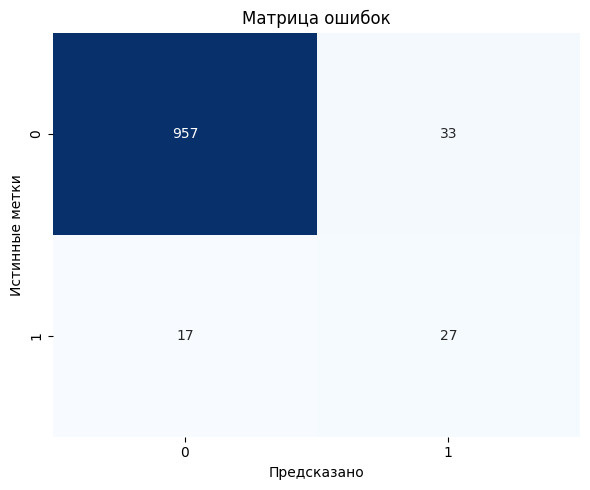

ROC AUC: 0.9205


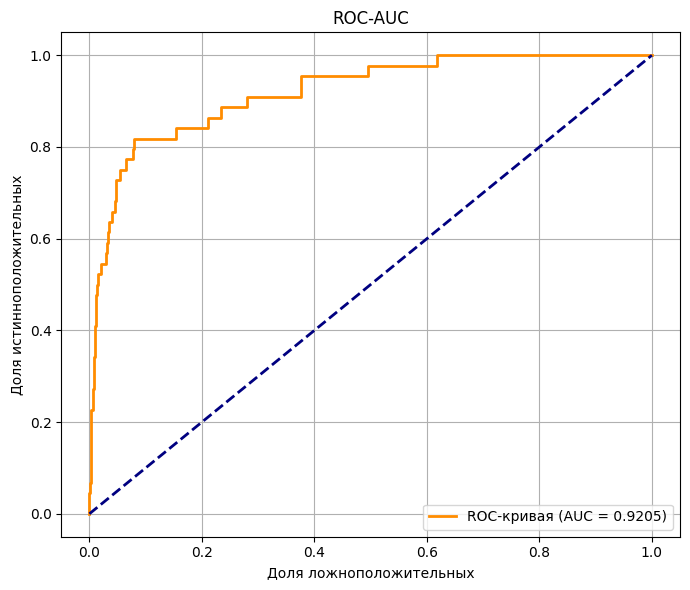

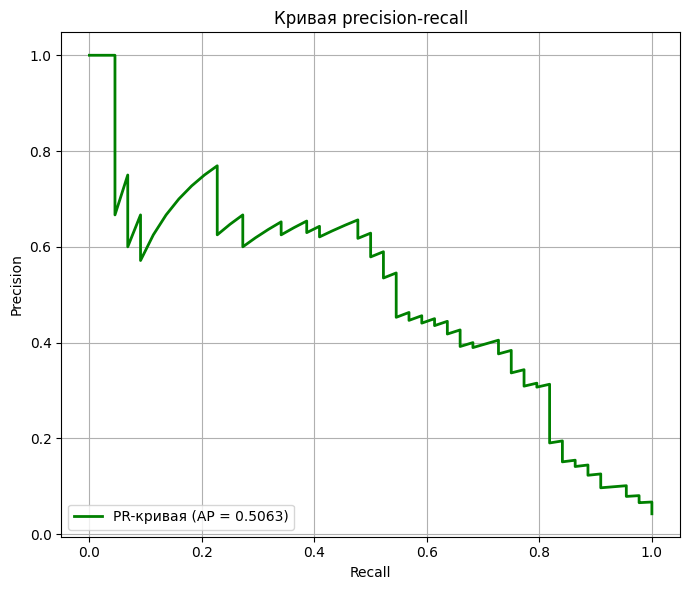

In [36]:
from scipy.sparse import hstack

def count_emojis(text):
    return len(emoji.distinct_emoji_list(text))

def extract_features(texts):
    features = []
    for text in texts:
        length = len(text)
        words = len(text.split())
        caps_ratio = sum(1 for c in text if c.isupper()) / (length + 1e-6)
        digits = sum(c.isdigit() for c in text)
        special = sum(c in "@#$%&*!?[]{}()-_=+\\/|^~`<>:;" for c in text)
        emojis_count = count_emojis(text)
        features.append([length, words, caps_ratio, digits, special, emojis_count])
    return np.array(features)

X_train_feats = extract_features(X_train)
X_val_feats = extract_features(X_val)
X_test_feats = extract_features(X_test)

X_train_combined = hstack([X_train_tfidf, X_train_feats])
X_val_combined = hstack([X_val_tfidf, X_val_feats])
X_test_combined = hstack([X_test_tfidf, X_test_feats])

Xy_train_df = pd.DataFrame(X_train_combined.toarray())
Xy_train_df["label"] = y_train.values

fraud = Xy_train_df[Xy_train_df["label"] == 1]
not_fraud = Xy_train_df[Xy_train_df["label"] == 0]

fraud_upsampled = resample(
    fraud,
    replace=True,
    n_samples=len(not_fraud),
    random_state=42
)

upsampled = pd.concat([not_fraud, fraud_upsampled])
X_train_resampled = upsampled.drop("label", axis=1)
y_train_resampled = upsampled["label"]

lr = LogisticRegression(max_iter=1000, n_jobs=-1)
lr.fit(X_train_resampled, y_train_resampled)

y_pred = lr.predict(X_val_combined)
y_proba = lr.predict_proba(X_val_combined)[:, 1]

evaluate_model(y_val, y_pred, y_proba)

### Случайный лес

Отчет классификации

              precision    recall  f1-score   support

           0     0.9762    0.9960    0.9860       990
           1     0.8333    0.4545    0.5882        44

    accuracy                         0.9729      1034
   macro avg     0.9048    0.7253    0.7871      1034
weighted avg     0.9702    0.9729    0.9691      1034

Точность (Accuracy): 0.9729


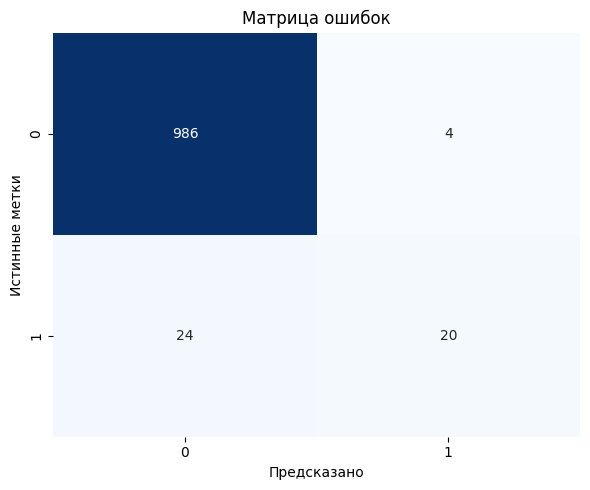

ROC AUC: 0.9682


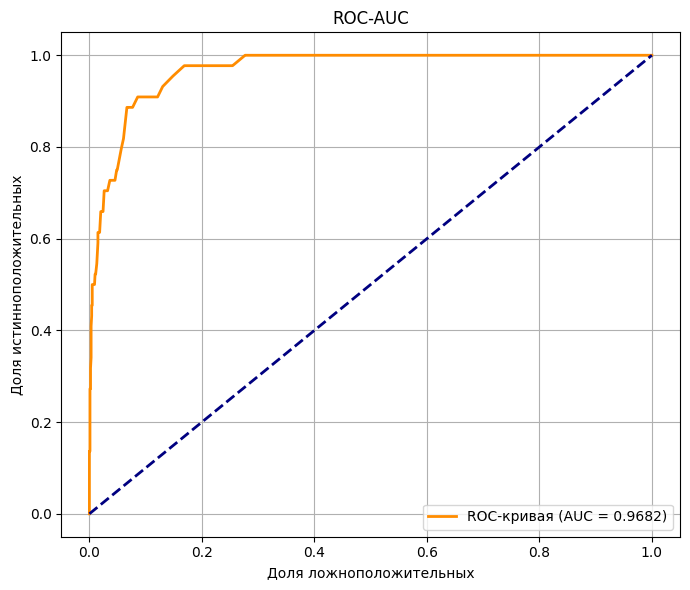

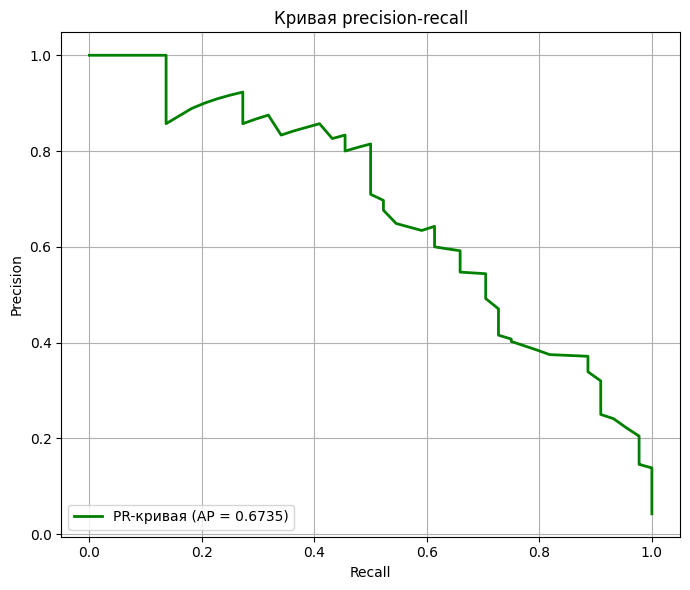

In [37]:
rf = RandomForestClassifier(
    n_estimators=100,     
    max_depth=None,        
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_resampled, y_train_resampled)

y_pred_rf = rf.predict(X_val_combined)
y_proba_rf = rf.predict_proba(X_val_combined)[:, 1]

evaluate_model(y_val, y_pred_rf, y_proba_rf)

### Catboost

0:	test: 0.6853421	best: 0.6853421 (0)	total: 91.1ms	remaining: 45.4s
100:	test: 0.9242883	best: 0.9242883 (100)	total: 3.11s	remaining: 12.3s
200:	test: 0.9358815	best: 0.9358815 (199)	total: 6.08s	remaining: 9.05s
300:	test: 0.9423783	best: 0.9424013 (299)	total: 9.16s	remaining: 6.06s
400:	test: 0.9443297	best: 0.9445363 (393)	total: 12.1s	remaining: 3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9445362718
bestIteration = 393

Shrink model to first 394 iterations.
Отчет классификации

              precision    recall  f1-score   support

           0     0.9742    0.9899    0.9820       990
           1     0.6429    0.4091    0.5000        44

    accuracy                         0.9652      1034
   macro avg     0.8085    0.6995    0.7410      1034
weighted avg     0.9601    0.9652    0.9615      1034

Точность (Accuracy): 0.9652


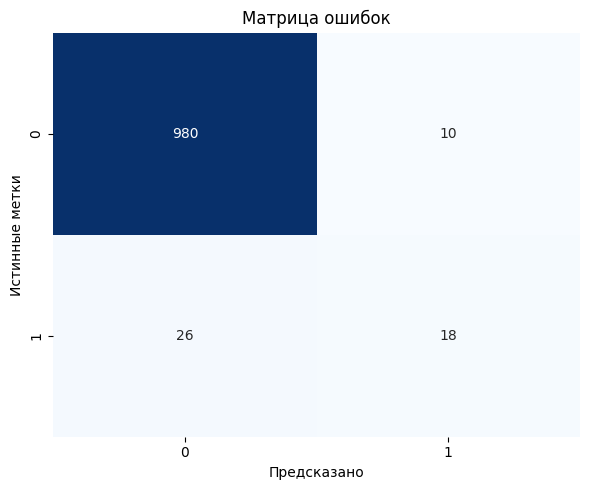

ROC AUC: 0.9445


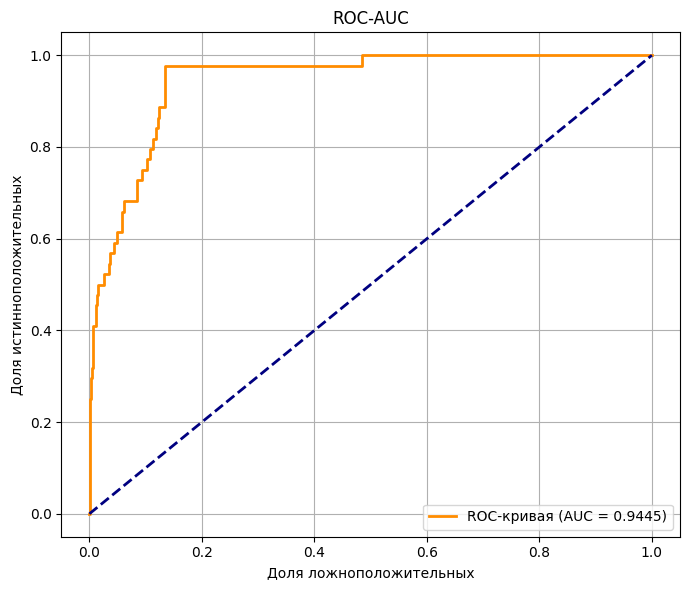

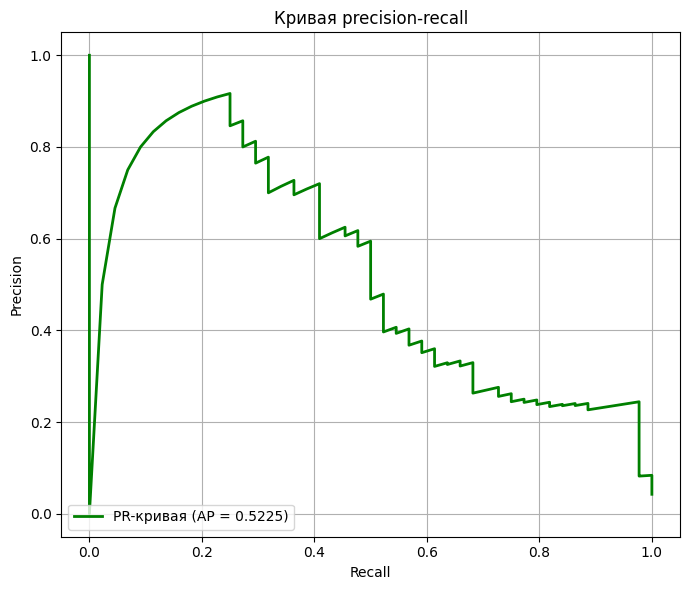

In [38]:
train_pool = Pool(data=X_train_combined, label=y_train.values)
val_pool = Pool(data=X_val_combined, label=y_val.values)

catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    eval_metric='AUC',
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50
)

catboost_model.fit(train_pool, eval_set=val_pool, use_best_model=True)

y_pred_cb = catboost_model.predict(val_pool)
y_proba_cb = catboost_model.predict_proba(val_pool)[:, 1]
evaluate_model(y_val, y_pred_cb, y_proba_cb)

### LSTM

In [39]:
def tokenize(texts):
    return [word_tokenize(t.lower()) for t in texts]

tokenized_all = tokenize(pd.concat([X_train, X_val, X_test]))
word_counts = Counter(word for tokens in tokenized_all for word in tokens)
vocab = {word: i+2 for i, (word, _) in enumerate(word_counts.most_common(20000))}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1

def encode_and_pad(tokens, vocab, max_len=100):
    encoded = [[vocab.get(word, 1) for word in tok] for tok in tokens]
    padded = [seq[:max_len] + [0]*(max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in encoded]
    return torch.tensor(padded)

X_train_pad = encode_and_pad(tokenize(X_train), vocab)
X_val_pad = encode_and_pad(tokenize(X_val), vocab)
X_test_pad = encode_and_pad(tokenize(X_test), vocab)

y_train_tensor = torch.tensor(y_train.values).float()
y_val_tensor = torch.tensor(y_val.values).float()
y_test_tensor = torch.tensor(y_test.values).float()

In [40]:
class CommentDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(CommentDataset(X_train_pad, y_train_tensor), batch_size=64, shuffle=True)
val_loader = DataLoader(CommentDataset(X_val_pad, y_val_tensor), batch_size=64)
test_loader = DataLoader(CommentDataset(X_test_pad, y_test_tensor), batch_size=64)

In [42]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=64, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True, dropout=dropout, num_layers=2)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, 1)  

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        h = torch.cat((h_n[-2], h_n[-1]), dim=1)  
        h = self.dropout(h)
        return self.fc(h).squeeze(1)

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_lstm = LSTMClassifier(vocab_size=len(vocab)).to(device)

pos_weight = torch.tensor([(len(y_train_tensor) - y_train_tensor.sum()) / y_train_tensor.sum()]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001)

epochs = 6

train_losses_per_epoch = []
val_losses_per_epoch = []
val_auc_per_epoch = []
val_f1_per_epoch = []

for epoch in range(epochs):
    model_lstm.train()
    train_losses = []

    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = model_lstm(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # Оценка на валидации
    model_lstm.eval()
    val_logits, val_targets = [], []
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            logits = model_lstm(X_val_batch)
            val_logits.extend(logits.cpu().numpy())
            val_targets.extend(y_val_batch.cpu().numpy())

    val_logits_tensor = torch.tensor(val_logits).to(device)
    val_targets_tensor = torch.tensor(val_targets).to(device)

    val_probs = torch.sigmoid(val_logits_tensor).cpu().numpy()
    val_preds = (val_probs > 0.5).astype(int)

    auc = roc_auc_score(val_targets, val_probs)
    f1 = f1_score(val_targets, val_preds)
    precision = precision_score(val_targets, val_preds)
    recall = recall_score(val_targets, val_preds)
    val_loss = criterion(val_logits_tensor, val_targets_tensor).item()

    # Сохранение метрик
    train_losses_per_epoch.append(np.mean(train_losses))
    val_losses_per_epoch.append(val_loss)
    val_auc_per_epoch.append(auc)
    val_f1_per_epoch.append(f1)

    print(f"Epoch {epoch+1}: Train Loss = {np.mean(train_losses):.4f}, Val Loss = {val_loss:.4f}, "
          f"AUC = {auc:.4f}, F1 = {f1:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}")

Epoch 1: 100%|██████████| 82/82 [00:01<00:00, 68.05it/s]


Epoch 1: Train Loss = 0.9569, Val Loss = 0.6982, AUC = 0.8540, F1 = 0.2162, Precision = 0.1246, Recall = 0.8182


Epoch 2: 100%|██████████| 82/82 [00:00<00:00, 196.92it/s]


Epoch 2: Train Loss = 0.4263, Val Loss = 0.4519, AUC = 0.9016, F1 = 0.5000, Precision = 0.4615, Recall = 0.5455


Epoch 3: 100%|██████████| 82/82 [00:00<00:00, 197.47it/s]


Epoch 3: Train Loss = 0.2079, Val Loss = 0.4596, AUC = 0.9111, F1 = 0.4696, Precision = 0.3803, Recall = 0.6136


Epoch 4: 100%|██████████| 82/82 [00:00<00:00, 198.94it/s]


Epoch 4: Train Loss = 0.1099, Val Loss = 0.3993, AUC = 0.9271, F1 = 0.5743, Precision = 0.5088, Recall = 0.6591


Epoch 5: 100%|██████████| 82/82 [00:00<00:00, 195.62it/s]


Epoch 5: Train Loss = 0.0618, Val Loss = 0.5028, AUC = 0.9318, F1 = 0.5149, Precision = 0.4561, Recall = 0.5909


Epoch 6: 100%|██████████| 82/82 [00:00<00:00, 197.54it/s]

Epoch 6: Train Loss = 0.0226, Val Loss = 0.6426, AUC = 0.9395, F1 = 0.5747, Precision = 0.5814, Recall = 0.5682


In [44]:
model_lstm.eval()
test_logits, test_targets = [], []
with torch.no_grad():
    for X_test_batch, y_test_batch in test_loader:
        X_test_batch = X_test_batch.to(device)
        logits = model_lstm(X_test_batch)
        test_logits.extend(logits.cpu().numpy())
        test_targets.extend(y_test_batch.numpy())

test_probs = torch.sigmoid(torch.tensor(test_logits)).numpy()
test_preds = (test_probs > 0.5).astype(int)

auc = roc_auc_score(test_targets, test_probs)
f1 = f1_score(test_targets, test_preds)
precision = precision_score(test_targets, test_preds)
recall = recall_score(test_targets, test_preds)

print(f"\nTest AUC = {auc:.4f}, F1 = {f1:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}")



Test AUC = 0.9286, F1 = 0.6410, Precision = 0.7576, Recall = 0.5556


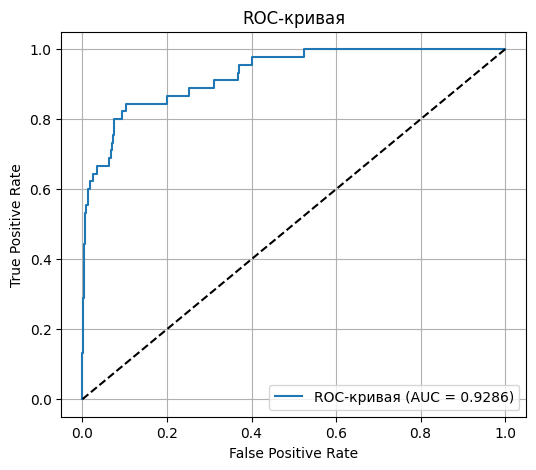

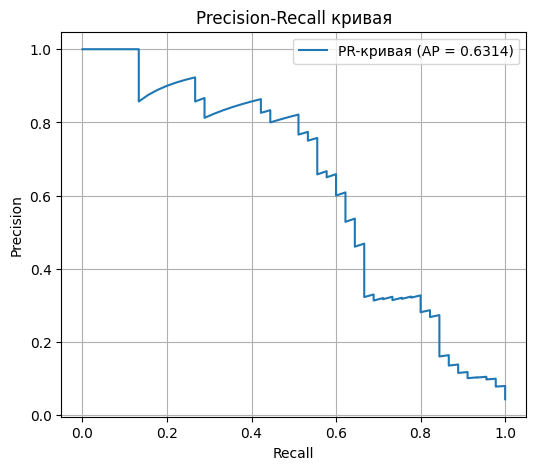

In [45]:
fpr, tpr, _ = roc_curve(test_targets, test_probs)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC-кривая (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.legend()
plt.grid(True)
plt.show()

precision_vals, recall_vals, _ = precision_recall_curve(test_targets, test_probs)
avg_prec = average_precision_score(test_targets, test_probs)
plt.figure(figsize=(6,5))
plt.plot(recall_vals, precision_vals, label=f"PR-кривая (AP = {avg_prec:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall кривая")
plt.legend()
plt.grid(True)
plt.show()

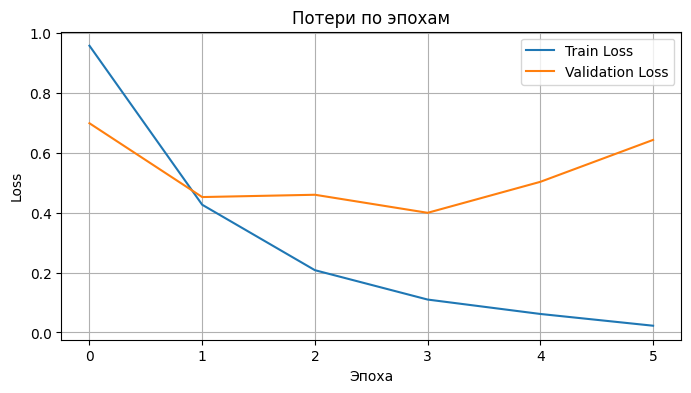

In [47]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses_per_epoch, label='Train Loss')
plt.plot(val_losses_per_epoch, label='Validation Loss')
plt.title("Потери по эпохам")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

### BERT из библиотеки transformers (Hugging Face) на PyTorch.

In [48]:
train_df = pd.DataFrame({'text': X_train.values, 'label': y_train.values})
val_df = pd.DataFrame({'text': X_val.values, 'label': y_val.values})
test_df = pd.DataFrame({'text': X_test.values, 'label': y_test.values})

In [49]:
class_labels = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=class_labels, y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

In [50]:
class CustomBERTWithLoss(nn.Module):
    def __init__(self, base_model, class_weights):
        super().__init__()
        self.base_model = base_model
        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            output_hidden_states=False,
            return_dict=True,
        )
        logits = outputs.logits
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
        
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions
        )
model_name = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights_tensor = class_weights_tensor.to(device)

model = CustomBERTWithLoss(base_model, class_weights_tensor)
model.to(device)

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CustomBERTWithLoss(
  (base_model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(119547, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out

In [51]:
train_dataset = datasets.Dataset.from_pandas(train_df)
val_dataset = datasets.Dataset.from_pandas(val_df)
test_dataset = datasets.Dataset.from_pandas(test_df)

def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

cols_to_remove = ["text", "__index_level_0__"] if "__index_level_0__" in train_dataset.column_names else ["text"]
train_dataset = train_dataset.remove_columns(cols_to_remove).with_format("torch")
val_dataset = val_dataset.remove_columns(cols_to_remove).with_format("torch")
test_dataset = test_dataset.remove_columns(cols_to_remove).with_format("torch")
train_dataset

Map:   0%|          | 0/5225 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/1034 [00:00<?, ? examples/s]

Map:   0%|          | 0/1035 [00:00<?, ? examples/s]

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 5225
})

In [53]:
def compute_metrics(pred):
    labels = pred.label_ids
    probs = pred.predictions[:, 1]  # вероятность положительного класса
    preds = pred.predictions.argmax(-1)
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    auc = roc_auc_score(labels, probs)
    
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall, "roc_auc": auc}

In [54]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    logging_steps=100,
    report_to="none"
)


In [55]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [56]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Roc Auc
1,0.268800,0.321123,0.975822,0.675325,0.787879,0.590909,0.976882
2,0.148700,0.163322,0.966151,0.695652,0.563380,0.909091,0.987948
3,0.079800,0.159271,0.983559,0.804598,0.813953,0.795455,0.991758
4,0.031900,0.108588,0.980658,0.807692,0.700000,0.954545,0.992792


TrainOutput(global_step=656, training_loss=0.13231417536735535, metrics={'train_runtime': 290.7151, 'train_samples_per_second': 71.892, 'train_steps_per_second': 2.257, 'total_flos': 0.0, 'train_loss': 0.13231417536735535, 'epoch': 4.0})

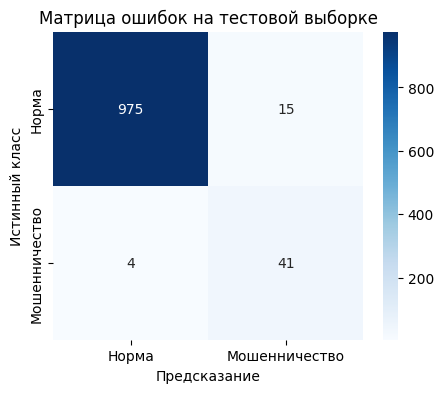

Отчёт по классификации на тесте:
               precision    recall  f1-score   support

        Норма       1.00      0.98      0.99       990
Мошенничество       0.73      0.91      0.81        45

     accuracy                           0.98      1035
    macro avg       0.86      0.95      0.90      1035
 weighted avg       0.98      0.98      0.98      1035



In [58]:
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(-1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Норма", "Мошенничество"], yticklabels=["Норма", "Мошенничество"])
plt.xlabel('Предсказание')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок на тестовой выборке')
plt.show()

print("Отчёт по классификации на тесте:")
print(classification_report(y_true, y_pred, target_names=["Норма", "Мошенничество"]))

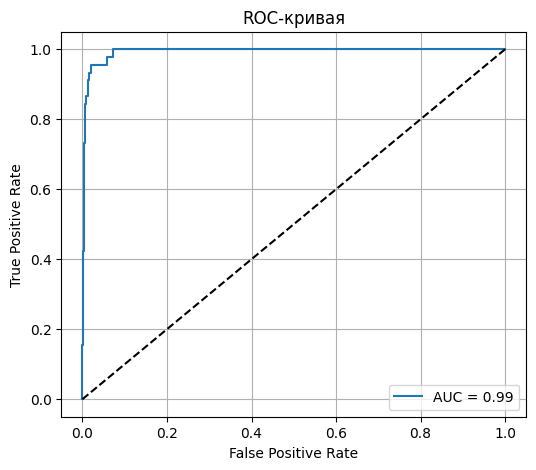

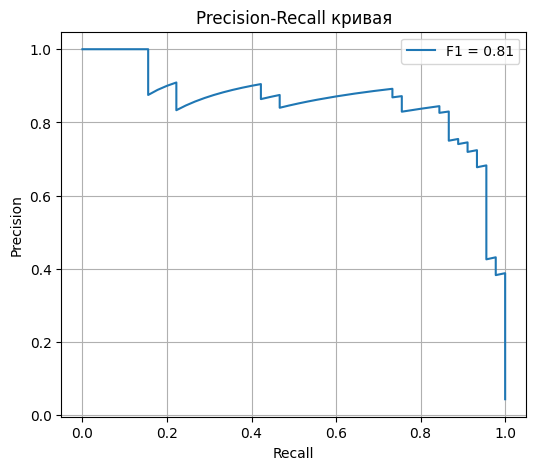

In [60]:
from sklearn.metrics import roc_curve

probs = predictions.predictions[:, 1]
fpr, tpr, _ = roc_curve(y_true, probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_true, probs):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.grid(True)
plt.show()

from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_true, probs)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"F1 = {f1_score(y_true, y_pred):.2f}")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall кривая')
plt.grid(True)
plt.legend()
plt.show()


Precision–Recall кривая демонстрирует высокую точность модели при увеличении полноты, что особенно важно для задач выявления мошенничества, где ложные срабатывания могут иметь последствия, но пропущенные случаи более критичны.

На графике видно, что модель поддерживает точность выше 80% вплоть до recall ≈ 0.85. Это свидетельствует о способности модели обнаруживать подавляющее большинство мошеннических сообщений, сохраняя при этом высокую избирательность.

Итоговая F1-мера на тестовой выборке составляет 0.81, что является сбалансированным компромиссом между точностью и полнотой при текущем пороге классификации.

In [62]:
model.base_model.save_pretrained("bert_model")
tokenizer.save_pretrained("bert_model")

('bert_model/tokenizer_config.json',
 'bert_model/special_tokens_map.json',
 'bert_model/vocab.txt',
 'bert_model/added_tokens.json',
 'bert_model/tokenizer.json')